In [ ]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np

from firedrake.petsc import PETSc

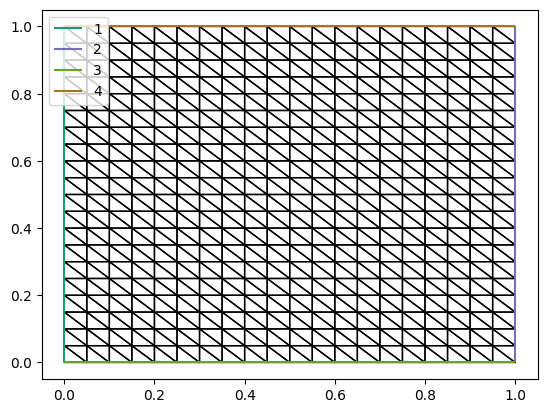

In [ ]:
n = 20  # per unit length
mesh = UnitSquareMesh(n, n)
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
ax.legend(loc='upper left')

In [ ]:
V=VectorFunctionSpace(mesh,'P',2)
Q=FunctionSpace(mesh,'P',1)
W=MixedFunctionSpace([V,Q])

x=SpatialCoordinate(mesh)

t_=Constant(0)
u_plate=as_vector((sin(2*pi*t_),0))
u_noslip=Constant((0,0))
bc_plate=DirichletBC(W.sub(0),u_plate,4)
bc_noslip=DirichletBC(W.sub(0),u_noslip,(1,2,3))
bcsU=(bc_plate,bc_noslip)

dt=0.01
T=1
nu=0.01
f=Constant((0,0))

In [ ]:
def linearized_problem(u,v,p,q,nu,dt,u_old):
  a=1/dt*inner(u,v)*dx\
    +dot(dot(grad(u),u_old),v)*dx\
    +2*nu*inner(sym(grad(u)),sym(grad(v)))*dx\
    -p*div(v)*dx\
    +q*div(u)*dx
  L=1/dt*inner(u_old,v)*dx
  return a,L

def stokes_initializzation(u,v,p,q,nu):
  a=+2*nu*inner(sym(grad(u)),sym(grad(v)))*dx\
      -p*div(v)*dx\
      +q*div(u)*dx
  L=dot(f,v)*dx
  return a,L


def snes_solver(u,v,p,q,nu,dt,u_old):
  G=1/dt*inner(u,v)*dx\
    +dot(dot(grad(u),u),v)*dx\
    +2*nu*inner(sym(grad(u)),sym(grad(v)))*dx\
    -p*div(v)*dx\
    +q*div(u)*dx\
    -1/dt*inner(u_old,v)*dx
  return G

In [ ]:
u,p=TrialFunctions(W)
v,q=TestFunctions(W)

wh_init=Function(W)
a_stokes,L_stokes=stokes_initializzation(u,v,p,q,nu)
problem_stokes=LinearVariationalProblem(a_stokes,L_stokes,wh_init,bcsU)
solver_stokes=LinearVariationalSolver(problem_stokes)
solver_stokes.solve()
uh_init,ph_init=wh_init.subfunctions

In [ ]:
param = ( {'snes_type':'newtonls', # nonlinear solver types: https://petsc.org/release/manual/snes/#the-nonlinear-solvers
       'snes_monitor':'',        # activate logging options
       'snes_monitoring_lg_residualnorm':'', # print ||G|| at each iteration
       'snes_rtol':1e-4, 'snes_atol':1e-10, 'snes_stol':1e-14, 'snes_maxit':1000
       })

In [ ]:
wh=Function(W)

uh_old=Function(V)
ph_old=Function(Q)
uh_old.assign(uh_init)
ph_old.assign(ph_init)


wh_snes=Function(W)
uh_snes,ph_snes=split(wh_snes)
dwh=TrialFunction(W)
G=snes_solver(uh_snes,v,ph_snes,q,nu,dt,uh_old)
J=derivative(G,wh_snes,dwh)
A=NonlinearVariationalProblem(G,wh_snes,bcsU,J)
solver_snes=NonlinearVariationalSolver(A,solver_parameters=param)
#solver_snes.solve()
#uh_snes,ph_snes=wh_snes.subfunctions

a,L=linearized_problem(u,v,p,q,nu,dt,uh_old)
problem=LinearVariationalProblem(a,L,wh,bcsU)
solver=LinearVariationalSolver(problem)
solver.solve()

In [ ]:
"""fig, ax = plt.subplots()
col = tripcolor(ph_snes, axes=ax)
plt.colorbar(col)
plt.title('pressure')
fig, ax = plt.subplots()
col = quiver(uh_snes, axes=ax)
plt.colorbar(col)
plt.title('velocity')"""

"fig, ax = plt.subplots()\ncol = tripcolor(ph_snes, axes=ax)\nplt.colorbar(col)\nplt.title('pressure')\nfig, ax = plt.subplots()\ncol = quiver(uh_snes, axes=ax)\nplt.colorbar(col)\nplt.title('velocity')"

In [ ]:
t_vec = np.arange(0, T+0.1*dt, dt)  # T+0.1*dt to include also T: range/arange exclude the upper bound of the range
drag_vec=[0]*len(t_vec)
normal=FacetNormal(mesh)
for ii in range(1, len(t_vec)):     # start from 1 to skip t=0
    t_val = t_vec[ii]
    print('Time = ', t_val)
    t_.assign(t_val)
    uh_snes,ph_snes=split(wh_snes)
    dwh=TrialFunction(W)
    G=snes_solver(uh_snes,v,ph_snes,q,nu,dt,uh_old)
    J=derivative(G,wh_snes,dwh)
    A=NonlinearVariationalProblem(G,wh_snes,bcsU,J)
    solver_snes=NonlinearVariationalSolver(A,solver_parameters=param)
    solver_snes.solve()
    uh_snes,ph_snes=wh_snes.subfunctions

    #print('||u||_H1',errornorm(uh,uh_old,'H1')/norm(uh_old,'H1'),'||p||_L2',errornorm(ph,ph_old,'L2')/norm(ph_old,'L2'))

    uh_snes.assign(uh_old)
    #ph_old.assign(ph)
    #drag_vec[ii] = assemble( inner( ph_old*normal - 2.0*nu*dot(sym(grad(uh_old)), normal), Constant((1.,0.)) ) * ds(3) )

Time =  0.01
  0 SNES Function norm 2.312578176475e-03
  1 SNES Function norm 1.429270634262e-05
  2 SNES Function norm 7.086299835823e-12
Time =  0.02
  0 SNES Function norm 8.456585383256e-03
  1 SNES Function norm 5.691291251534e-05
  2 SNES Function norm 1.118848422992e-10
Time =  0.03
  0 SNES Function norm 1.617459210657e-02
  1 SNES Function norm 1.271416952787e-04
  2 SNES Function norm 5.561312354026e-10
Time =  0.04
  0 SNES Function norm 2.395149141827e-02
  1 SNES Function norm 2.238282359189e-04
  2 SNES Function norm 1.717050039472e-09
Time =  0.05
  0 SNES Function norm 3.168195667561e-02
  1 SNES Function norm 3.454088874593e-04
  2 SNES Function norm 4.074536416592e-09
Time =  0.06
  0 SNES Function norm 3.931899748031e-02
  1 SNES Function norm 4.899325645771e-04
  2 SNES Function norm 8.170566498994e-09
Time =  0.07
  0 SNES Function norm 4.682616261581e-02
  1 SNES Function norm 6.550920357372e-04
  2 SNES Function norm 1.456349475469e-08
Time =  0.08
  0 SNES Funct

Text(0.5, 1.0, 'velocity')

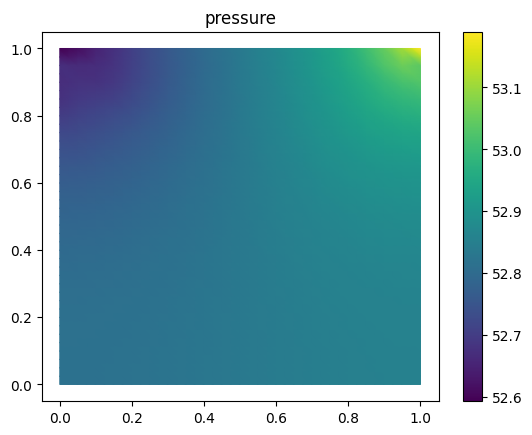

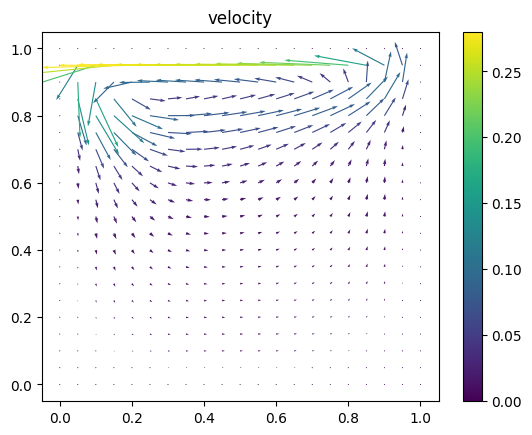

In [ ]:
fig, ax = plt.subplots()
col = tripcolor(ph_snes, axes=ax)
plt.colorbar(col)
plt.title('pressure')
fig, ax = plt.subplots()
col = quiver(uh_snes, axes=ax)
plt.colorbar(col)
plt.title('velocity')

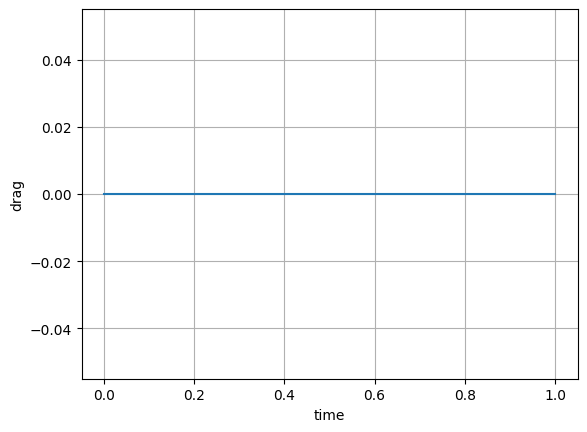

In [ ]:
plt.plot(t_vec, drag_vec)
plt.xlabel('time')
plt.ylabel('drag')
plt.grid()

In [ ]:
#Sanity check sness